In [1]:
# Imports
import torch
from torch import nn
torch.cuda.empty_cache()
from torch.nn.functional import interpolate

from hr_dv2 import HighResDV2, torch_pca
import hr_dv2.transform as tr
from hr_dv2.utils import *
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import mmcv

torch.manual_seed(0)
np.random.seed(0)

from featup.util import norm, unnorm
use_norm = True


/home/ronan/HR-Dv2/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
C = 384
L = 518

In [3]:
def load_img(path: str) -> tuple[torch.Tensor, np.ndarray]:
    temp_img = Image.open(path)
    h, w = temp_img.height, temp_img.width
    transform = tr.closest_crop(h, w) #tr.get_input_transform(L, L)
    tensor, img = tr.load_image(path, transform)
    H, W = img.height, img.width
    return tensor, np.array(img)

In [4]:
backbone_name = "dinov2_vits14"
net = HighResDV2(backbone_name, 7, dtype=torch.float16) #dino_vits8 #dinov2_vits14_reg
net.interpolation_mode = 'bilinear'
net.eval()
net.cuda()

fwd_shift, inv_shift = tr.get_shift_transforms([1, 2, 3], 'Moore')
fwd_flip, inv_flip = tr.get_flip_transforms()
fwd, inv = tr.combine_transforms(fwd_shift, fwd_flip, inv_shift, inv_flip)
net.set_transforms(fwd_shift, inv_shift)

Using cache found in /home/ronan/.cache/torch/hub/facebookresearch_dinov2_main
/home/ronan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/ronan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/ronan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")
/home/ronan/HR-Dv2/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [5]:
vanilla = HighResDV2(backbone_name, 14, dtype=torch.float16)
vanilla.eval()
vanilla.cuda()
vanilla.interpolation_mode = 'bilinear'

Using cache found in /home/ronan/.cache/torch/hub/facebookresearch_dinov2_main


In [6]:
jbu = torch.hub.load("mhamilton723/FeatUp", 'dinov2', use_norm=use_norm)
jbu.eval()
jbu.cuda()
pass

Using cache found in /home/ronan/.cache/torch/hub/mhamilton723_FeatUp_main
/home/ronan/HR-Dv2/.venv/lib/python3.10/site-packages/featup-0.1.2-py3.10-linux-x86_64.egg/featup/featurizers/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/ronan/HR-Dv2/.venv/lib/python3.10/site-packages/featup-0.1.2-py3.10-linux-x86_64.egg/featup/featurizers/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/ronan/HR-Dv2/.venv/lib/python3.10/site-packages/featup-0.1.2-py3.10-linux-x86_64.egg/featup/featurizers/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")
Using cache found in /home/ronan/.cache/torch/hub/facebookresearch_dinov2_main


In [7]:
class LinearHead(nn.Module):
    def __init__(self, n_classes: int) -> None:
        super().__init__()
        self.bn = nn.SyncBatchNorm(C)
        self.conv_seg = nn.Conv2d(C, n_classes, 1, 1)
    
    def forward(self, feats: torch.Tensor) -> torch.Tensor:
        feats = feats.to(torch.float)
        feats = self.bn(feats)
        return self.conv_seg(feats)

In [8]:
def semantic_seg(tensor: torch.Tensor, feat_net: nn.Module, linear_head: nn.Module, ) -> np.ndarray:
    B, C, H, W = tensor.shape
    if type(feat_net) == HighResDV2:
        tensor = tensor.squeeze(0)
    feats = feat_net(tensor)
    feats = interpolate(feats, (H, W))
    seg = linear_head(feats)
    print(seg.shape)
    preds = torch.argmax(seg, dim=1).detach().cpu().numpy()
    return preds

In [9]:
def apply_state_dict(raw_cfg: dict, linear_head: nn.Module) -> None:
    new_state_dict = {}
    for keys, vals in raw_cfg["state_dict"].items():
        new_key = keys.replace("decode_head.", "")
        new_state_dict[new_key] = vals
    linear_head.load_state_dict(new_state_dict)
    linear_head.cuda()
    linear_head.eval()

In [10]:
which = "voc"
if which == "ade":
    print('ade')
    model = LinearHead(150)
    cfg = torch.load('fig_data/dinov2_vits14_ade20k_linear_head.pth')
else:
    print('voc')
    model = LinearHead(21)
    cfg = torch.load('fig_data/dinov2_vits14_voc2012_linear_head.pth')

mmcv_cfg = mmcv.Config(cfg['meta'])

ade


In [11]:
def bit_get(val, idx):
    """Gets the bit value.
    Args:
      val: Input value, int or numpy int array.
      idx: Which bit of the input val.
    Returns:
      The "idx"-th bit of input val.
    """
    return (val >> idx) & 1


def create_pascal_label_colormap():
    """Creates a label colormap used in PASCAL VOC segmentation benchmark.
    Returns:
      A colormap for visualizing segmentation results.
    """
    colormap = np.zeros((512, 3), dtype=int)
    ind = np.arange(512, dtype=int)

    for shift in reversed(list(range(8))):
        for channel in range(3):
            colormap[:, channel] |= bit_get(ind, channel) << shift
        ind >>= 3

    return colormap
cmap = create_pascal_label_colormap()

In [12]:
img_tensor, img_arr = load_img('fig_data/6.jpg')
img_tensor = img_tensor.cuda().unsqueeze(0)

In [13]:
model.cuda()
model.eval()

LinearHead(
  (bn): SyncBatchNorm(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_seg): Conv2d(384, 150, kernel_size=(1, 1), stride=(1, 1))
)

In [20]:
pred = semantic_seg(img_tensor, jbu, model)
pred.shape

torch.Size([1, 150, 308, 308])


/home/ronan/HR-Dv2/.venv/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


(1, 308, 308)

In [24]:
cmap_arr = np.array(mmcv_cfg['PALETTE'])
print(pred.shape)
recoloured = cmap[pred]

(1, 308, 308)


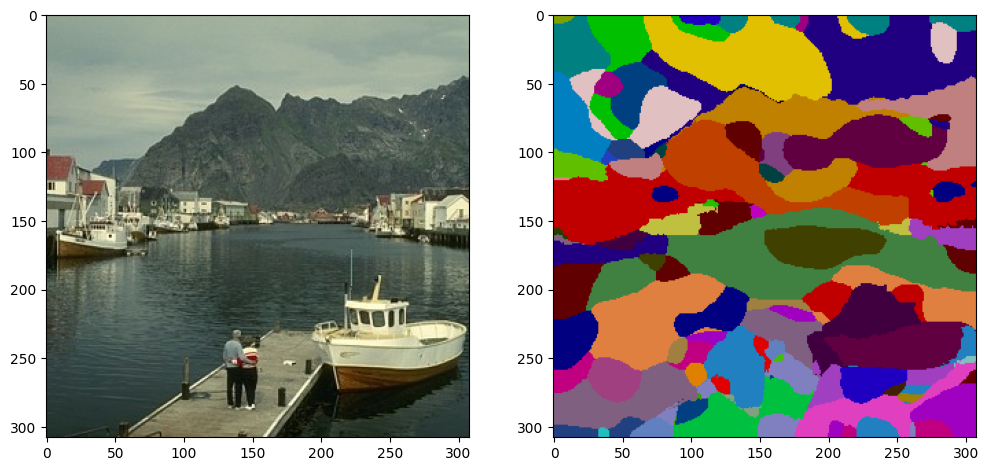

In [25]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(12, 8)
axs[0].imshow(img_arr)
axs[1].imshow(recoloured[0])